In [1]:
import pandas as pd
import psycopg2
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix

In [3]:
def savePearson(pearson,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO wordspearson(word,p1,p2,patient,deadPatient)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(p1)s) ,'
                      ' unnest( %(p2)s) ,'
                      ' unnest( %(patient)s) ,'
                      ' unnest( %(deadPatient)s)')
    word=[r['word'] for r in pearson]
    p1=[r['p1'] for r in pearson]
    p2=[r['p2'] for r in pearson]
    patient=[r['patient'] for r in pearson]
    deadPatient=[r['deadPatient'] for r in pearson]
#    print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [4]:
def selectPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT word,p1,p2,patient,deadpatient FROM wordspearson'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement)
    select = []
    for row in cur :
        patient=row[3]
        cuantosMueren ="{0:.2%}".format(row[4]/patient)+" de "+str(patient)
        select.append({"word":row[0],"p1":row[1],"p2":row[2],"cuantosMueren":cuantosMueren})
    cur.close()
    conn.close()
    return sorted(select, key=itemgetter('p1'), reverse=True)

In [5]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [6]:
def cleanPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    delete_statement='DELETE FROM wordspearson'
#    print(cur.mogrify(delete_statement,locals()))
    cur.execute(delete_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [7]:
table = convert_matrix(sumvals=False)
table

(590, 58840)


,,aaaaaaa,aaaaaaaa,aaaaaaab,aaaaaaac,aaaaaaad,aaaaaaae,aaaaaaaf,aaaaaaag,aaaaaaah,aaaaaaai,...,kkb,kke,lab,lbb,lbbb,lbbc,lcc,leb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,1,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
263,1,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,1,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
survived = table.index.labels[1].tolist()
patients = table.values
columns = list(table.columns.values)

In [9]:
cleanPearson()
print("cleanedPearson now reading",len(columns),"columns")
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    pearsonList.append({'word':word,'p1':pearson[0],'p2':pearson[1],'patient':count['patient'],'deadPatient':count['deadPatient']})
#    print(i,end=", ")
print(" preparedToSavePearson")
savePearson(pearsonList)
print("savedPearson")

cleanedPearson now reading 58840 columns
 preparedToSavePearson
savedPearson


In [10]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [11]:
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(590, 58840)
(472, 58840)
(118, 58840)


In [13]:
model,accuracy_score,logit_roc_auc = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

In [14]:
model

LogisticRegressionCV(Cs=[0.007966, 0.0080488, 0.008131600000000001, 0.0082144, 0.008297200000000001, 0.00838],
           class_weight=None, cv=5, dual=True, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=0, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)

In [7]:
from operator import itemgetter
pearsonDict = selectPearson()

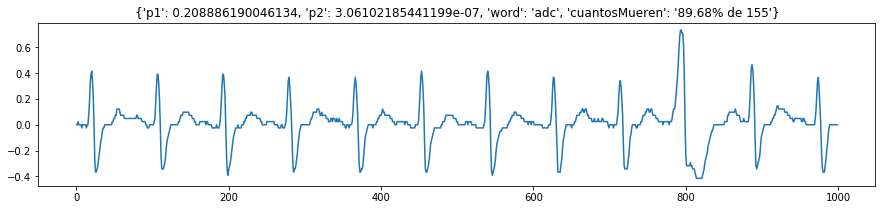

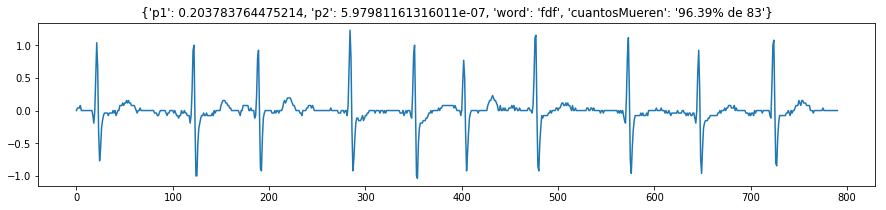

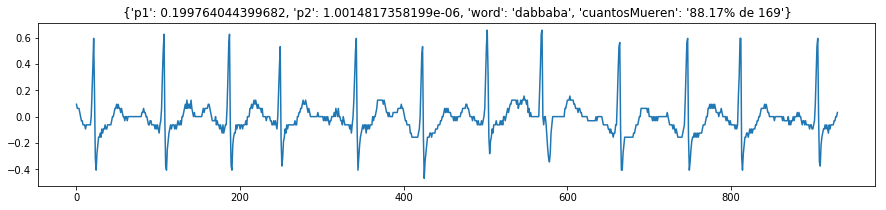

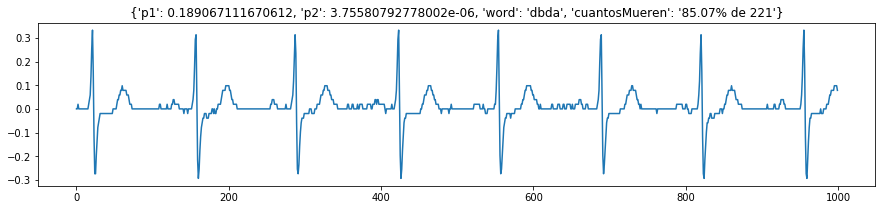

b"SELECT v1.r_s,v8.q_s,v1.record,a.rec_from\n    FROM rstq v1\n    INNER JOIN a on a.record=v1.record INNER JOIN rstq v2 on v1.record=v2.record  INNER JOIN rstq v3 on v2.record=v3.record  INNER JOIN rstq v4 on v3.record=v4.record  INNER JOIN rstq v5 on v4.record=v5.record  INNER JOIN rstq v6 on v5.record=v6.record  INNER JOIN rstq v7 on v6.record=v7.record  INNER JOIN rstq v8 on v7.record=v8.record  WHERE v1.centroid ='d'  AND v2.centroid='a' AND v1.id+1=v2.id  AND v3.centroid='b' AND v2.id+1=v3.id  AND v4.centroid='a' AND v3.id+1=v4.id  AND v5.centroid='a' AND v4.id+1=v5.id  AND v6.centroid='a' AND v5.id+1=v6.id  AND v7.centroid='a' AND v6.id+1=v7.id  AND v8.centroid='d' AND v7.id+1=v8.id  AND v1.r_s<v8.q_s\n    AND a.record NOT IN ('mimic2wdb/matched/s20354/s20354-2526-08-25-00-53',\n    'mimic2wdb/matched/s14584/s14584-2721-07-20-18-49',\n    'mimic2wdb/matched/s18413/s18413-3047-06-23-22-31',\n    'mimic2wdb/matched/s16032/s16032-3339-07-31-12-58')\n    LIMIT 1"
dabaaaad 89179756 8

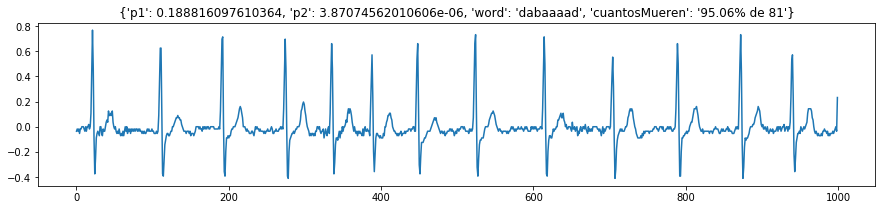

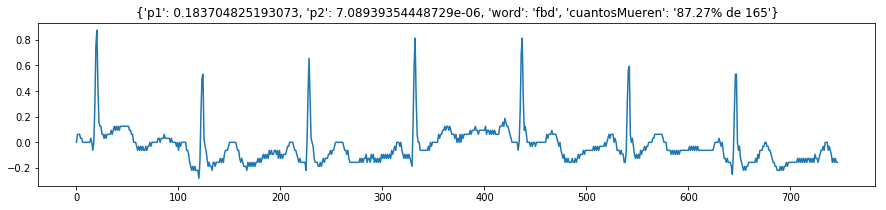

In [8]:
plot_word(pearsonDict[:10])

In [9]:
df = pd.DataFrame(pearsonDict)
df = df.set_index('word')
df = df.sort_values(['p1'], ascending=[False])
df

,cuantosMueren,p1,p2
word,,,
adc,89.68% de 155,0.208886,3.061022e-07
fdf,96.39% de 83,0.203784,5.979812e-07
dabbaba,88.17% de 169,0.199764,1.001482e-06
dbda,85.07% de 221,0.189067,3.755808e-06
dabaaaad,95.06% de 81,0.188816,3.870746e-06
fbd,87.27% de 165,0.183705,7.089394e-06
dff,93.18% de 88,0.180136,1.071184e-05
ffd,91.26% de 103,0.177633,1.424185e-05
fff,93.83% de 81,0.177530,1.440773e-05
